In [1]:
from labvision import video, images
from scipy import ndimage
from tqdm import tqdm
import cv2
import numpy as np

In [2]:
liquid_file = "/media/data/Data/Orderphobic/TwoIntruders/FoamPlaIntruders/Logging/091220_x_liquid_wide_gap_570/0912320_x_liquid_wide_gap_570.mp4"
solid_file = "/media/data/Data/Orderphobic/TwoIntruders/FoamPlaIntruders/Logging/081220_x_solid_wide_gap_570/0812320_x_solid_wide_gap_570.mp4"

In [3]:
liquid = video.ReadVideo(liquid_file)
solid = video.ReadVideo(solid_file)

In [4]:
(liquid.num_frames, solid.num_frames)

(7200, 7200)

In [5]:
def get_angle(ps):
    dy = ps[2, 1] - ps[3, 1]
    dx = ps[2, 0] - ps[3, 0]
    angle = np.arctan2(dy, dx)
    return 360-angle * 180 / np.pi

In [6]:
def get_crop_result_and_rotation_angle(vid):
    frame = vid.read_frame()
    vid.set_frame(0)
    res = images.crop_polygon(frame)
    angle = get_angle(res.points)
    print(angle)
#     frame = ndimage.rotate(frame, angle, reshape=False)
    frame = images.rotate(frame, angle)
    res = images.crop_rectangle(frame)
    return res, angle

In [7]:
def get_frame(vid, angle, res):
    frame = vid.read_frame()
#     frame = ndimage.rotate(frame, angle, reshape=False)
    frame = images.rotate(frame, angle)
    frame = images.crop_and_mask(frame, res.bbox, res.mask)
    return frame

In [27]:
solid_crop_result, solid_angle = get_crop_result_and_rotation_angle(solid)

300.8105281103631


In [24]:
liquid_crop_result, liquid_angle = get_crop_result_and_rotation_angle(liquid)

300.6682372859554


In [28]:
liquid_frame = get_frame(liquid, liquid_angle, liquid_crop_result)
solid_frame = get_frame(solid, solid_angle, solid_crop_result)

In [29]:
liquid_frame.shape, solid_frame.shape

((132, 825, 3), (136, 824, 3))

In [33]:
frame = liquid_frame

In [92]:
def get_circles(f):
    r = f[:, :, 0] - f[:, :, 2]
    r = images.opening(r, (31, 31))
    r = images.threshold(r, 70)
    w = r.shape[1]
    r1, r2 = r[:, :w//2], r[:, w//2:]
    m1 = list(images.center_of_mass(r1))
    m2 = list(images.center_of_mass(r2))
    m2[0] += w//2
    return m1, m2

In [93]:
def draw_circles(frame, c1, c2):
    f = frame.copy()
    f = images.draw_circle(f, c1[0], c1[1], 5)
    f = images.draw_circle(f, c2[0], c2[1], 5)
    return f

In [37]:
annotated_frame = draw_circles(frame, c1, c2)

In [38]:
images.display(annotated_frame)

In [94]:
lx1, lx2, sx1, sx2 = [], [], [], []
liquid.set_frame(0)
solid.set_frame(0)
for f in tqdm(range(liquid.num_frames)):
    try:
        liquid_frame = get_frame(liquid, liquid_angle, liquid_crop_result)
        solid_frame = get_frame(solid, solid_angle, solid_crop_result)
        l1, l2 = get_circles(liquid_frame)
        s1, s2 = get_circles(solid_frame)
        lx1.append(l1[0])
        lx2.append(l2[0])
        sx1.append(s1[0])
        sx2.append(s2[0])
    except:
        pass
            

100%|██████████| 7200/7200 [05:46<00:00, 20.76it/s]


In [95]:
len(lx1)

7200

In [96]:
len(lx2)

7200

In [97]:
save_dir = "/media/data/Data/Orderphobic/TwoIntruders/FoamPlaIntruders/Logging/08-09_logs"

In [104]:
np.savetxt(f"{save_dir}/lx1.txt", lx1)
np.savetxt(f"{save_dir}/lx2.txt", lx2)
np.savetxt(f"{save_dir}/sx1.txt", sx1)
np.savetxt(f"{save_dir}/sx2.txt", sx2)

In [99]:
min(sx1), max(sx2)

(122, 688)

In [100]:
bins = np.arange(50, 750)

In [101]:
ln1, _ = np.histogram(lx1, bins=bins)
ln2, _ = np.histogram(lx2, bins=bins)
sn1, _ = np.histogram(sx1, bins=bins)
sn2, _ = np.histogram(sx2, bins=bins)

In [102]:
import matplotlib.pyplot as plt

<BarContainer object of 699 artists>

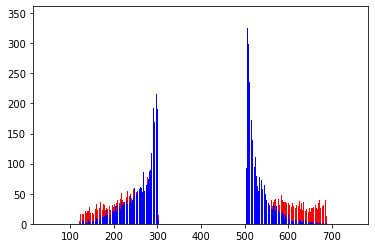

In [103]:
plt.figure()
plt.bar(bins[:-1], ln1, color='r')
plt.bar(bins[:-1], ln2, color='r')
plt.bar(bins[:-1], sn1, color='b')
plt.bar(bins[:-1], sn2, color='b')

In [82]:
window = images.Displayer('solid')
solid.set_frame(0)
for f in range(solid.num_frames):
    frame = get_frame(solid, solid_angle, solid_crop_result)
    frame = images.draw_circle(frame, sx1[f], frame.shape[0]//2, 20)
    frame = images.draw_circle(frame, sx2[f], frame.shape[0]//2, 20)
    window.update_im(frame)

KeyboardInterrupt: 